RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2016.1.0
*** Git changeset:  f4e22e59622b42182d16059f0212ddb1c6aa8712
*** -------------------------------------------------------------------------


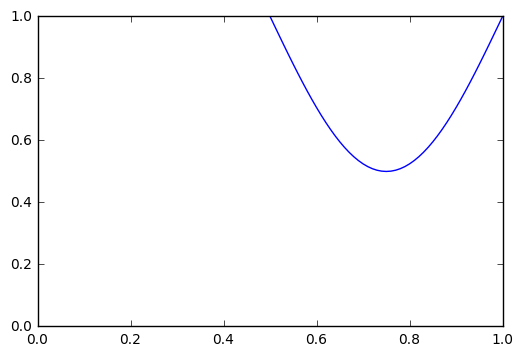

In [24]:
%matplotlib inline
from dolfin import *

nc = 100
T  = 0.02  # final time
h  = 1.0/nc
ep = Constant(h)
dt = h
idt= Constant(1.0/dt)

# Sub domain for Dirichlet boundary condition
class Boundary(SubDomain):
   def inside(self, x, on_boundary):
      return (x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS) and on_boundary

   def map(self, x, y):
      y[0] = x[0] - 1.0

# Initial condition
u0 = Expression("1.0+0.5*sin(2*pi*x[0])",degree=1)

# Load mesh
mesh = UnitIntervalMesh(nc)

# Defining the function spaces
V = FunctionSpace(mesh, "CG", 1, constrained_domain=Boundary())

# Test and trial functions
v = TestFunction(V)
u = Function(V)
du = TrialFunction(V)
uold = Function(V)  # previous solution

ux = u.dx(0)
vx = v.dx(0)
K  = u/sqrt(ux**2 + ep**2)
R = idt*(u-uold)*v*dx + K*ux*vx*dx 
J  = derivative(R, u, du)  # Gateaux derivative in dir. of du

problem = NonlinearVariationalProblem(R, u, J=J)
solver  = NonlinearVariationalSolver(problem)
prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 1E-8
prm['newton_solver']['relative_tolerance'] = 1E-2
prm['newton_solver']['maximum_iterations'] = 100
prm['newton_solver']['relaxation_parameter'] = 0.1

# Set initial condition
u.interpolate(u0)
plot(u)
uold.assign(u)
solver.solve()
plot(u)

In [5]:
plot?